# Counterfactual Search

0. Brain Networks
1. Black-box function
2. Counterfactual Search: DS - Dataset Search
3. Counterfactual Search: OFS - Oblivious Forward Search
3. Counterfactual Search: DFS - Data-driven Forward Search
4. Counterfactual Search: OBS - Oblivious Backward Search
4. Counterfactual Search: DBS - Data-driven Backward Search

## 0. Brain Networks: from correlation matices to graphs

In [1]:
#import graph
import os
import numpy as np
import csv
import matplotlib
import matplotlib.pyplot as plt


data = {}
path = '../data/ADHD/ADHD200_CC200/'
i=0
map_dict = {}
files = os.listdir(path)
files = sorted(files)
for filename in files:
    if 'DS_Store' not in filename:
        with open(path+filename, mode='r') as txt_file: 
            name = filename.split('.')[0]
            file_type = name.split('_')[-3]
            if file_type == 'connectivity':
                #print(i,' ',name)
                name = '_'.join(name.split('_')[:-3])
                lines = txt_file.readlines()
                m = []
                for l in lines:
                    m.append([float(el) for el in l.split(' ')])
                data[name] = np.array(m)
                map_dict[i] = [name]
                i+=1

In [2]:
print('There are {} graphs'.format(len(list(data.keys()))))
print('Each with dimension ', data['NYU_1567356'].shape)

There are 520 graphs
Each with dimension  (190, 190)


In [3]:
path = '../data/ADHD/'
labels_file = 'subject_labels_list.txt'
labels_l = []
j=0
with open(path+labels_file, mode='r') as txt_file:
    lines = txt_file.readlines()
    for l in lines:
        labels_l.append(l)
        if l[0]=='A':
            map_dict[j].append(1)
        else:
            map_dict[j].append(0)
        j+=1

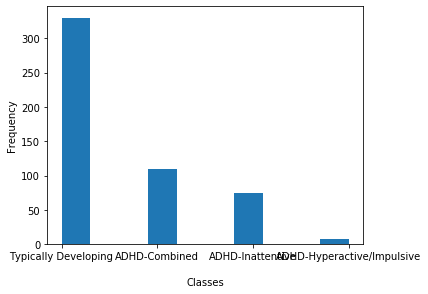

In [4]:
# Histogram
num_bins = 30

fig, ax = plt.subplots()
n, bins, patches = plt.hist(labels_l, density=False)

# add a 'best fit' line
#ax.set_title('''Total Edges for each dataset's graph''')

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
#plt.legend()
plt.ylabel('Frequency')
plt.xlabel('Classes')
#plt.savefig('Histogram_edges.png') # to save the plot
plt.show()

In [5]:
# Put labels with graphs
for k,v in map_dict.items():
    data[v[0]] = (v[1],data[v[0]])

## 0. Brain Network: network preprocessing

In [6]:
def tot_edges(g):
    '''Returns the total number of edges for undirected graphs
    '''
    return sum([sum(el) for el in g])/2

def edit_distance(g_1,g_2):
    '''
    '''
    return tot_edges(abs(g_1-g_2))

In [7]:
def create_graph(g,t):
    '''
    '''
    dim = len(g)
    distribution = []
    for i in range(0,dim):
        for j in range(i+1,dim):
            el = abs(g[i][j])
            distribution.append(el)
    distribution.sort()
    p = np.percentile(distribution,t)
    g_new = np.zeros((dim,dim))
    for i in range(0,dim):
        for j in range(i+1,dim):
            if abs(g[i][j])>=p:
                g_new[i][j]=1
                g_new[j][i]=1
    return g_new

In [8]:
def preprocessing_g(g,p_low,p_high):
    '''
    '''
    dim = len(g)
    distribution = []
    for i in range(0,dim):
        for j in range(i+1,dim):
            el = g[i][j]
            distribution.append(el)
    distribution.sort()
    p_min = np.percentile(distribution,p_low)
    p_max = np.percentile(distribution,p_high)
    print(p_min,p_max)
    g_new = np.zeros((dim,dim))
    for i in range(0,dim):
        for j in range(i+1,dim):
            if g[i][j]>p_max or g[i][j]<p_min:
                g_new[i][j]=1
                g_new[j][i]=1
    return g_new

In [9]:
def create_graph2(g,t):
    '''
    '''
    dim = len(g)
    distribution = []
    for i in range(0,dim):
        for j in range(i+1,dim):
            el = g[i][j]
            distribution.append(el)
    distribution.sort()
    p = np.percentile(distribution,t)
    g_new = np.zeros((dim,dim))
    for i in range(0,dim):
        for j in range(i+1,dim):
            if g[i][j]>=p:
                g_new[i][j]=1
                g_new[j][i]=1
    return g_new

In [10]:
t = 90
t1 = 5
t2 = 95
graphs = {}
tot_edges_list = []
for k,v in data.items():
    #g = create_graph(v[1],t)
    #g = preprocessing_g(v[1],t1,t2)
    g = create_graph2(v[1],t)
    graphs[k] = (v[0],g)
    tot_edges_list.append(tot_edges(g))

## 0. Brain Networks: datset distribution

In [11]:
hist_l0 = [tot_edges(v[1]) for k,v in graphs.items() if v[0]==0]
hist_l1 = [tot_edges(v[1]) for k,v in graphs.items() if v[0]==1]
hist_l = [hist_l0,hist_l1]

In [12]:
avg_0 = sum(hist_l0)/len(hist_l0)
avg_1 = sum(hist_l1)/len(hist_l1)
print('{}, {}'.format(round(avg_0, 0),round(avg_1, 0)))

1796.0, 1796.0


## 0. Brain Networks: save graphs
If you want to save graphs in single files, or in a .pickle file compute the newt two blocks

In [16]:
# Write graphs to .txt files
td_or_adhd = {0:'td',1:'adhd'}
outputpath = '../data/ADHD/graphs'
for k,v in graphs.items():
    name = k
    g = v[1]
    label = v[0]
    mat = np.matrix(g)
    file_path = outputpath+'/'+ td_or_adhd[label]+'/'+'{}.txt'.format(name)
    np.savetxt(file_path,mat,fmt='%i')

In [17]:
len(list(graphs.keys()))

520

In [90]:
import pickle
outputpath = '/Users/Carlo/graphcounterfactuals/code/ADHD/'
with open(outputpath+'graphs3.pickle', 'wb') as handle:
    pickle.dump(graphs, handle, protocol=pickle.HIGHEST_PROTOCOL)

#with open(outputpath+'graphs3.pickle', 'rb') as handle:
#    graphs_c = pickle.load(handle)

## 1. Black-box function: embedding
The contrast subgraphs are computed as described in https://github.com/tlancian/contrast-subgraph

In [19]:

# alpha=0.01
adhd_td = [1, 2, 171, 179, 7, 139, 14, 15, 16, 19, 20, 22, 151, 154, 156, 160, 33, 35, 165, 168, 169, 42, 135, 173, 46, 47, 177, 51, 54, 184, 185, 186, 59, 32, 68, 182, 71, 74, 75, 79, 83, 89, 96, 97, 99, 106, 113, 114, 115]
td_adhd = [1, 130, 132, 6, 7, 11, 12, 13, 18, 21, 152, 153, 30, 161, 162, 35, 134, 38, 167, 41, 170, 43, 174, 175, 178, 180, 158, 187, 62, 63, 65, 69, 70, 71, 76, 77, 80, 82, 84, 85, 86, 92, 94, 100, 101, 102, 105, 108, 117, 122, 124, 126, 127]

In [20]:
print('common nodes ',sum([1 for i in td_adhd if i in adhd_td]))
common_nodes = [i for i in td_adhd if i in adhd_td]
print(common_nodes)

common nodes  4
[1, 7, 35, 71]


In [21]:
# create the induced subgraph
def sub_graph(g,v_sub,verbose=False):
    '''To generate the sub graph
    '''
    g_sub = np.copy(g)
    l_1 = [el for el in v_sub]
    g_sub = g_sub[np.ix_(l_1,l_1)]
    return g_sub

def coeff_ab(g,td_asd,asd_td):
    '''
    '''
    # Induce the sub-graphs
    g_td_asd = sub_graph(g,td_asd)
    g_asd_td = sub_graph(g,asd_td)

    # Coefficients
    a = sum([sum(i) for i in g_td_asd])/2
    b = sum([sum(i) for i in g_asd_td])/2

    return a,b

In [22]:
ab_list = []
for k,v in graphs.items():
    name = k
    g = v[1]
    label = v[0]
    a,b = coeff_ab(g,td_adhd,adhd_td)
    ab_list.append((a,b,label))

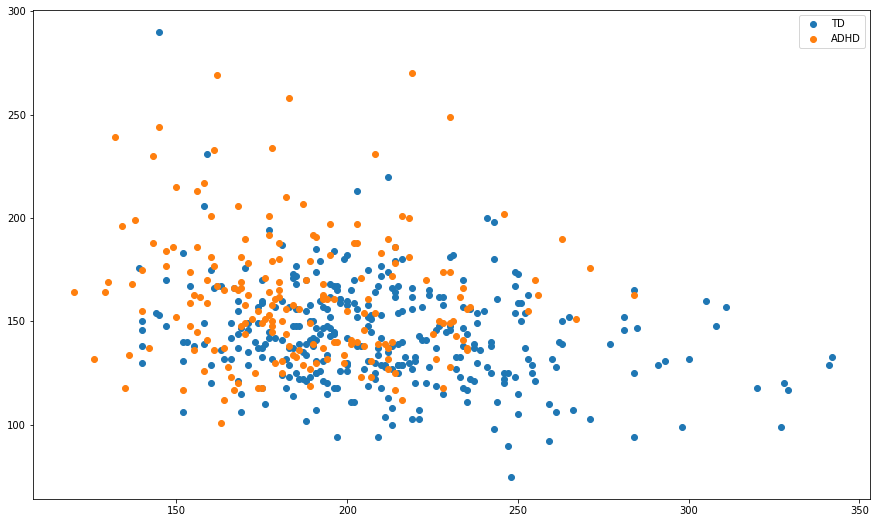

In [23]:
# Visualize the 2d-space
X_0 = np.array([[a,b] for a,b,y in ab_list if y==0])
X_1 = np.array([[a,b] for a,b,y in ab_list if y==1])
plt.figure(figsize=(15,9))
plt.scatter(X_0[:, 0], X_0[:, 1], label= 'TD')
plt.scatter(X_1[:, 0], X_1[:, 1], label= 'ADHD')
plt.legend()

## 1. Black-box function: create the classifier

In [24]:
def classifiers(x_train,y_train,x_test,y_test):
    '''
    '''
    results_i = []
    models = []
    
    # KNN
    training_accuracy = [] 
    test_accuracy = []
    kn_models = []
    neighbors_settings = range(1, 30)
    for n_neighbors in neighbors_settings:
        # build the model
        clf = KNeighborsClassifier(n_neighbors=n_neighbors) 
        clf.fit(x_train, y_train)
        # record training set accuracy 
        training_accuracy.append(clf.score(x_train, y_train)) 
        # record generalization accuracy 
        scc = clf.score(x_test, y_test)
        test_accuracy.append(scc)
        kn_models.append(clf)
    kn = test_accuracy.index(max(test_accuracy))
    results_i.append(test_accuracy[kn])
    models.append(kn_models[kn])
    
    # SCM
    test_accuracy_svm = []
    clf = svm.SVC(kernel='linear', C = 1.0)
    clf.fit(x_train, y_train)
    results_i.append(clf.score(x_test, y_test))
    models.append(clf)
    
    return results_i,models

In [25]:
import random
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier 
from sklearn import svm
yx0 = [(y,[a,b]) for a,b,y in ab_list if y==0]
yx1 = [(y,[a,b]) for a,b,y in ab_list if y==1]
random.shuffle(yx0)
random.shuffle(yx1)
lenmax = max(len(yx0),len(yx1))
yx0 = yx0[:lenmax]
yx1 = yx1[:lenmax]
yx = yx0 + yx1
random.shuffle(yx)
X = np.array([el[1] for el in yx])
Y = np.array([el[0] for el in yx])
##
kf = KFold(n_splits=5,shuffle=True)
kf.get_n_splits(X)
i = 0
results = {}
models_classifier = {}
for train_index, test_index in kf.split(X):
    train_index = list(train_index)
    test_index = list(test_index)
    #print("TRAIN:", len(train_index), "TEST:", len(test_index))
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    print(len(X_train),len(X_test),len(y_train),len(y_test))
    #x_train,y_train,x_test,y_test =train_test_sets(,dim_1,dim_2)
    # Classifiers
    results[i],models_classifier[i] = classifiers(X_train,y_train,X_test,y_test)
    i+=1

416 104 416 104
416 104 416 104
416 104 416 104
416 104 416 104
416 104 416 104


In [26]:
results

{0: [0.6730769230769231, 0.6826923076923077],
 1: [0.7403846153846154, 0.7115384615384616],
 2: [0.7019230769230769, 0.6634615384615384],
 3: [0.7692307692307693, 0.7692307692307693],
 4: [0.7307692307692307, 0.6634615384615384]}

In [30]:
clf = models_classifier[3][1]

## 1. Black-box function: visualize the results

In [32]:
# Line Coefficients
w_1 = clf.coef_[0][0]
w_2 = clf.coef_[0][1]
bk = clf.intercept_[0]
print('w_1 = {}'.format(clf.coef_[0][0])) # (w_1,w_2) : w_1*x_1 + w_2*x_2 + b = 0
print('w_2 = {}'.format(clf.coef_[0][1])) # (w_1,w_2) : w_1*x_1 + w_2*x_2 + b = 0
print('bk = {}'.format(clf.intercept_[0])) # (w_1,w_2) : w_1*x_1 + w_2*x_2 + b = 0

w_1 = -0.011585911313886754
w_2 = 0.01859629649334238
bk = -1.1019324122260894


In [33]:
# create the induced subgraph
def sub_graph(g,v_sub):
    '''To create the sub graph og 'g' from the list of nodes in 'v_sub'.
    '''
    g_sub = np.copy(g)
    #l_1 = [el for el in v_sub]
    l_1 = [el for el in v_sub]
    g_sub = g_sub[np.ix_(l_1,l_1)]
    return g_sub

def oracle(g):
    ''' The classification funcion for the graph 'g'
    '''
    # Sub-graphs
    #td_adhd = [130, 4, 133, 6, 136, 140, 13, 144, 17, 18, 19, 151, 132, 26, 27, 167, 30, 159, 161, 162, 155, 36, 37, 38, 39, 170, 43, 172, 175, 48, 177, 178, 180, 158, 183, 56, 57, 60, 61, 62, 67, 69, 70, 73, 76, 78, 141, 85, 86, 176, 91, 92, 94, 100, 105, 107, 108, 112, 114, 116, 120, 121, 124, 126, 127]
    #adhd_td = [128, 1, 2, 150, 134, 7, 11, 15, 145, 146, 147, 22, 151, 156, 32, 33, 35, 164, 163, 166, 40, 169, 42, 171, 173, 46, 47, 177, 50, 179, 53, 54, 184, 185, 186, 168, 188, 189, 181, 64, 160, 66, 68, 182, 71, 72, 74, 75, 143, 81, 82, 83, 89, 90, 91, 165, 97, 187, 104, 106, 113, 114, 115, 118, 120]

    # Induced sub-graphs
    g_td_adhd = sub_graph(g,td_adhd)
    g_adhd_td = sub_graph(g,adhd_td)

    # Coefficients
    a = sum([sum(i) for i in g_td_adhd])/2
    b = sum([sum(i) for i in g_adhd_td])/2

    # Apply the rule
    x = bk + w_1*a + w_2*b
    

    # Classify
    if x>0:
        return 1#,a,b #'ASD'
    else:
        return 0#,a,b#'TD'
    
def oracle_ab(g):
    ''' The classification funcion for the graph 'g' with some information on the classification (a, b parameters)
    '''
    #td_adhd = [130, 4, 133, 6, 136, 140, 13, 144, 17, 18, 19, 151, 132, 26, 27, 167, 30, 159, 161, 162, 155, 36, 37, 38, 39, 170, 43, 172, 175, 48, 177, 178, 180, 158, 183, 56, 57, 60, 61, 62, 67, 69, 70, 73, 76, 78, 141, 85, 86, 176, 91, 92, 94, 100, 105, 107, 108, 112, 114, 116, 120, 121, 124, 126, 127]
    #adhd_td = [128, 1, 2, 150, 134, 7, 11, 15, 145, 146, 147, 22, 151, 156, 32, 33, 35, 164, 163, 166, 40, 169, 42, 171, 173, 46, 47, 177, 50, 179, 53, 54, 184, 185, 186, 168, 188, 189, 181, 64, 160, 66, 68, 182, 71, 72, 74, 75, 143, 81, 82, 83, 89, 90, 91, 165, 97, 187, 104, 106, 113, 114, 115, 118, 120]

    # Induced sub-graphs
    g_td_adhd = sub_graph(g,td_adhd)
    g_adhd_td = sub_graph(g,adhd_td)

    # Coefficients
    a = sum([sum(i) for i in g_td_adhd])/2
    b = sum([sum(i) for i in g_adhd_td])/2

    # Apply the rule
    x = bk + w_1*a + w_2*b

    # Classify
    if x>0:
        return 1,a,b #'ASD'
    else:
        return 0,a,b#'TD'

In [34]:
#name_o = 'KKI_0050777'
info = []
results = {'pred':[],'true':[]}
for name,v in graphs.items():
    g_o = v[1] # Original graph
    y = v[0]
    y_hat,a,b = oracle_ab(g_o)
    #print('The graph {} with lable {} is classified as {}'.format(name,y,y_hat))
    results['pred'].append(y_hat)
    results['true'].append(y)
    info.append((y_hat,y,a,b))

In [35]:
sum([v[0] for k,v in graphs.items()]),sum([1 for k,v in graphs.items() if v[0]==0])

(190, 330)

In [36]:
sum([1 for el in info if el[0]==el[1]])/len(info)

0.7076923076923077

In [37]:
l_0_a_tot = [el[2] for el in info if el[1]==0]
l_0_b_tot = [el[3] for el in info if el[1]==0]
l_1_a_tot = [el[2] for el in info if el[1]==1]
l_1_b_tot = [el[3] for el in info if el[1]==1]
l_a_tot = [el[2] for el in info]
l_b_tot = [(bk+(w_1*el[2]))/(-w_2) for el in info]

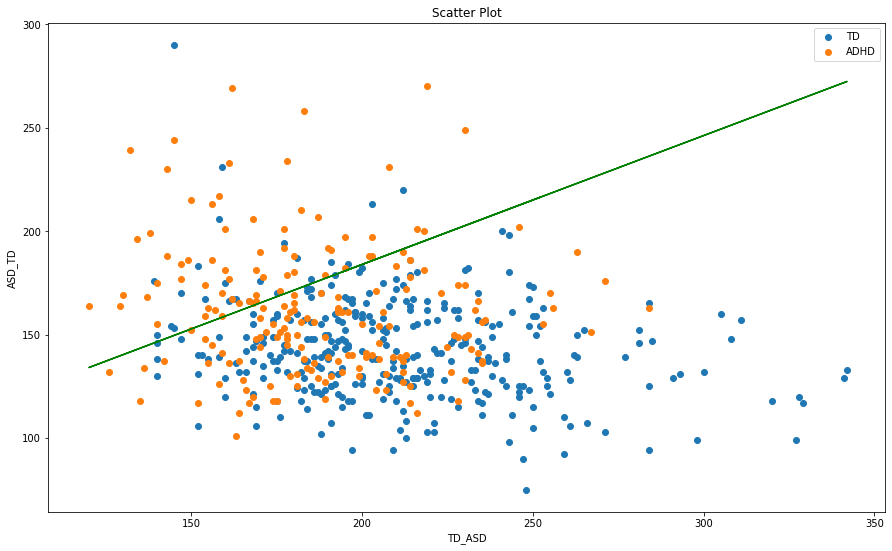

In [38]:
# Plot 

plt.figure(figsize=(15,9))


plt.scatter(X_0[:, 0], X_0[:, 1], label= 'TD')
plt.scatter(X_1[:, 0], X_1[:, 1], label= 'ADHD')

#plt.plot(l_0_a_tot,l_0_b_tot,'bo',label="TD")
#plt.plot(l_1_a_tot,l_1_b_tot,'ro',label="ASD")
plt.plot(l_a_tot,l_b_tot,'g-')
#plt.ylim(100.0, 350.0)
#plt.xlim(100.0, 250.0)
plt.title('Scatter Plot')
plt.ylabel('ASD_TD')
plt.xlabel('TD_ASD')
plt.legend()
#plt.savefig('Scatter_plot.png')
plt.show()

In [39]:
from sklearn.metrics import confusion_matrix,accuracy_score
tn, fp, fn, tp = confusion_matrix(results['true'],results['pred']).ravel()
print('Results:\n- {} TP;\n- {} TN;\n- {} FP;\n- {} FN.'.format(tp,tn,fp,fn))
accuracy = accuracy_score(results['true'],results['pred'])
print('Accuracy = {}'.format(accuracy))

Results:
- 63 TP;
- 305 TN;
- 25 FP;
- 127 FN.
Accuracy = 0.7076923076923077


## 2. Counterfactual Search: DS - Dataset Search

In [44]:
def dataset_distance(data,g_name):
    ''' Sort of the datasets graph (classified in the counterfactual class y_bar) 
        by edit distance.
    '''
    g = data[g_name][1] # original graph
    y_hat = oracle(g)
    y_bar = 1-y_hat
    l=1
    cname = ''
    dc=10000
    for name,v in data.items():
        y_i = v[0]
        if name != g_name and y_i==(1-y_bar):
            d = edit_distance(g,v[1])
            if d<dc:
                y_hat_i = oracle(v[1])
                l += 1
                if y_hat_i==y_bar:
                    cname = name
    return name,l 

In [45]:
%%time
results_dataset = {}
dataset_d = {}
k = 0
for gname,v in graphs.items():
    print(k, end=' - ')
    k+=1
    cname,l = dataset_distance(graphs,gname)
    d = edit_distance(g,graphs[cname][1])
    results_dataset[gname] = (d,l)
    dataset_d[gname] = cname


0 - 1 - 2 - 3 - 4 - 5 - 6 - 7 - 8 - 9 - 10 - 11 - 12 - 13 - 14 - 15 - 16 - 17 - 18 - 19 - 20 - 21 - 22 - 23 - 24 - 25 - 26 - 27 - 28 - 29 - 30 - 31 - 32 - 33 - 34 - 35 - 36 - 37 - 38 - 39 - 40 - 41 - 42 - 43 - 44 - 45 - 46 - 47 - 48 - 49 - 50 - 51 - 52 - 53 - 54 - 55 - 56 - 57 - 58 - 59 - 60 - 61 - 62 - 63 - 64 - 65 - 66 - 67 - 68 - 69 - 70 - 71 - 72 - 73 - 74 - 75 - 76 - 77 - 78 - 79 - 80 - 81 - 82 - 83 - 84 - 85 - 86 - 87 - 88 - 89 - 90 - 91 - 92 - 93 - 94 - 95 - 96 - 97 - 98 - 99 - 100 - 101 - 102 - 103 - 104 - 105 - 106 - 

KeyboardInterrupt: 

In [84]:
print('Average Edit Distance:')
sum([edit_distance(graphs[k][1],graphs[v][1]) for k,v in dataset_d.items()])/len(list(dataset_d.keys()))

2248.5615384615385

## 4. Counterfactual Search: OBS - Oblivious Backward Search

In [53]:
def get_change_list(g1,g2):
    edges = []
    g_diff = abs(g1-g2)
    dim_g = len(g1)
    for i in range(dim_g):
        for j in range(i,dim_g):
            if g_diff[i][j]==1:
                edges.append((i,j))
    return edges

In [54]:
def bb(g,gc1,y_bar,k=5,l_max=2000):
    '''
    '''
    info = []
    gc = np.copy(gc1)
    edges = get_change_list(g,gc)
    d = edit_distance(g,gc)
    random.shuffle(edges)
    li=0
    while(li<l_max and len(edges)>0 and d>1):
        ki = min(k,len(edges))
        gci = np.copy(gc)
        edges_i = [edges.pop(0) for i in range(ki)]
        for i,j in edges_i:
            if gci[i][j]>0.5:
                gci[i][j] = 0
                gci[j][i] = 0
            else:
                gci[i][j] = 1
                gci[j][i] = 1
        r = oracle(gci)
        li += 1
        if r==y_bar:
            gc = np.copy(gci)
            d = edit_distance(g,gc)
            #print('ok --> ',r,d,l,k)
            info.append((r,d,li,ki))
            k+=1
        else:
            d = edit_distance(g,gc)
            info.append((r,d,li,ki))
            if k>1:
                k-=1
                edges = edges + edges_i
    return gc,edit_distance(g,gc),li,info

In [56]:
%%time
lambda_g = 2000
k = 10
info_k_dist = {}
max_m = len(graphs.keys())
r_bb = {}
for q in range(3):
    print(q)
    m = 1
    r_bb_i = {}
    for oname,v in graphs.items():
        print('{}/{}'.format(m,max_m), end=' - ')
        m+=1
        g = v[1]
        y_hat = oracle(g)
        gc_name = dataset_d[oname]
        gc = graphs[gc_name][1]
        d_initial = edit_distance(g,gc)
        gc2,d,l,info = bb(g,gc,abs(1-y_hat))
#        info = sum(info.values(), [])
        d_final = edit_distance(g,gc2)
        r_bb_i[oname] = [d_final,l,y_hat,d_initial,info,gc2]
    r_bb[q] = r_bb_i

0
1/520 - 2/520 - 3/520 - 4/520 - 5/520 - 6/520 - 7/520 - 8/520 - 9/520 - 10/520 - 11/520 - 12/520 - 13/520 - 14/520 - 15/520 - 16/520 - 17/520 - 18/520 - 19/520 - 20/520 - 21/520 - 22/520 - 23/520 - 24/520 - 25/520 - 26/520 - 27/520 - 28/520 - 29/520 - 30/520 - 31/520 - 32/520 - 33/520 - 34/520 - 35/520 - 36/520 - 37/520 - 38/520 - 39/520 - 40/520 - 41/520 - 42/520 - 43/520 - 44/520 - 45/520 - 46/520 - 47/520 - 48/520 - 49/520 - 50/520 - 51/520 - 52/520 - 53/520 - 54/520 - 55/520 - 56/520 - 57/520 - 58/520 - 59/520 - 60/520 - 61/520 - 62/520 - 63/520 - 64/520 - 65/520 - 66/520 - 67/520 - 68/520 - 69/520 - 70/520 - 71/520 - 72/520 - 73/520 - 74/520 - 75/520 - 76/520 - 77/520 - 78/520 - 79/520 - 80/520 - 81/520 - 82/520 - 83/520 - 84/520 - 85/520 - 86/520 - 87/520 - 88/520 - 89/520 - 90/520 - 91/520 - 92/520 - 93/520 - 94/520 - 95/520 - 96/520 - 97/520 - 98/520 - 99/520 - 100/520 - 101/520 - 102/520 - 103/520 - 104/520 - 105/520 - 106/520 - 107/520 - 108/520 - 109/520 - 110/520 - 111/52

1/520 - 2/520 - 3/520 - 4/520 - 5/520 - 6/520 - 7/520 - 8/520 - 9/520 - 10/520 - 11/520 - 12/520 - 13/520 - 14/520 - 15/520 - 16/520 - 17/520 - 18/520 - 19/520 - 20/520 - 21/520 - 22/520 - 23/520 - 24/520 - 25/520 - 26/520 - 27/520 - 28/520 - 29/520 - 30/520 - 31/520 - 32/520 - 33/520 - 34/520 - 35/520 - 36/520 - 37/520 - 38/520 - 39/520 - 40/520 - 41/520 - 42/520 - 43/520 - 44/520 - 45/520 - 46/520 - 47/520 - 48/520 - 49/520 - 50/520 - 51/520 - 52/520 - 53/520 - 54/520 - 55/520 - 56/520 - 57/520 - 58/520 - 59/520 - 60/520 - 61/520 - 62/520 - 63/520 - 64/520 - 65/520 - 66/520 - 67/520 - 68/520 - 69/520 - 70/520 - 71/520 - 72/520 - 73/520 - 74/520 - 75/520 - 76/520 - 77/520 - 78/520 - 79/520 - 80/520 - 81/520 - 82/520 - 83/520 - 84/520 - 85/520 - 86/520 - 87/520 - 88/520 - 89/520 - 90/520 - 91/520 - 92/520 - 93/520 - 94/520 - 95/520 - 96/520 - 97/520 - 98/520 - 99/520 - 100/520 - 101/520 - 102/520 - 103/520 - 104/520 - 105/520 - 106/520 - 107/520 - 108/520 - 109/520 - 110/520 - 111/520 

In [65]:
# d_final,l,y_hat,d_initial,info,gc2
qq = len(r_bb)
ed = []
la = []
not_found = []
for name in list(r_bb[0].keys()):
    ed.append(np.array([r_bb[q][name][0] for q in range(qq)]))
    la.append(np.array([r_bb[q][name][1] for q in range(qq)]))
    not_found.append(np.array([name for q in range(qq) if r_bb[q][name][0]<1]))
ed_avstd = [round(np.std(el),2) for el in ed]
la_avstd = [round(np.std(el),2) for el in la]

In [71]:
# d_final,l,y_hat,d_initial,info,gc2

qq = len(r_bb)
ed_avg = []
ed_min = []
la_avg = []
for name in list(r_bb[0].keys()):
    ed_avg.append(sum([r_bb[q][name][0] for q in range(qq)])/qq)
    ed_min.append(min([r_bb[q][name][0] for q in range(qq)]))
    la_avg.append(sum([r_bb[q][name][1] for q in range(qq)])/qq)

In [73]:
print('Edit Distance: Average')
print('& {} & {} & {} & {} & {}'.format(np.quantile(ed_min,0.10),np.quantile(ed_min,0.25),np.quantile(ed_min,0.50),
                                        np.quantile(ed_min,0.75),np.quantile(ed_min,0.90)))

Edit Distance: Average
& 8.0 & 20.0 & 43.0 & 69.0 & 98.20000000000005


In [78]:
print('Edit Distance: Average')
print('& {} & {} & {} & {} & {}'.format(round(np.quantile(ed_avg,0.10),1),
                                        round(np.quantile(ed_avg,0.25),1),
                                        round(np.quantile(ed_avg,0.50),1),
                                        round(np.quantile(ed_avg,0.75),1),
                                        round(np.quantile(ed_avg,0.90),1)))

Edit Distance: Average
& 9.0 & 20.6 & 43.8 & 70.0 & 100.2


In [79]:
print('Lambda: Avg')
print('& {} & {} & {} & {} & {}'.format(round(np.quantile(la_avg,0.10),1),
                                        round(np.quantile(la_avg,0.25),1),
                                        round(np.quantile(la_avg,0.50),1),
                                        round(np.quantile(la_avg,0.75),1),
                                        round(np.quantile(la_avg,0.90),1)))

Lambda: Avg
& 173.2 & 249.2 & 406.0 & 578.2 & 764.7


## 4. Counterfactual Search: OBS - Oblivious Backward Search (variant)

In [79]:
def get_change_list(g1,g2):
    edges = []
    g_diff = abs(g1-g2)
    dim_g = len(g1)
    for i in range(dim_g):
        for j in range(i,dim_g):
            if g_diff[i][j]==1:
                edges.append((i,j))
    return edges

In [80]:
def k_back_search(g,gc1,y_bar,k,l,lambda_f=2000):
    '''
    '''
    info = []
    dim = len(g)
    gc = np.copy(gc1)
    edges = get_change_list(g,gc)
    d = edit_distance(g,gc)
    random.shuffle(edges) #g_dist
    #print(y_bar,len(edges),d)
    while(l<lambda_f and len(edges)>0 and d>1):
        if k>len(edges):
            k=len(edges)-1
        gci = np.copy(gc)
        edges_i = [edges.pop(0) for i in range(k)]
        for i,j in edges_i:
            if gci[i][j]>0.5:
                gci[i][j] = 0
                gci[j][i] = 0
            else:
                gci[i][j] = 1
                gci[j][i] = 1
        r = oracle(gci)
        l += 1
        if r==y_bar:
            gc = np.copy(gci)
            d = edit_distance(g,gc)
            #print('ok --> ',r,d,l,k)
            info.append((r,d,l,k))
            k+=1
        else:
            k-=1
            if k<1:
                k=1
            if len(edges)<2:
                return gc,l,d,k,info
            info.append((r,d,l,k))
            #print('no --> ',r,d,l,k)
    return gc,l,edit_distance(g,gc),k,info

In [81]:
def k_backward(g,gc,y_bar,k=5,l_max=2000):
    ''''''
    l=0
    d_old=edit_distance(g,gc)
    d=d_old-1
    gci = np.copy(gc)
    info = {}
    q=0
    while(d>0 and d<d_old and l<l_max):
        #print('-->',q,oracle(gci),y_bar,k,l,d)
        d_old=d
        gci,l,d,k,info_i = k_back_search(g,gci,y_bar,k,l)
        #l+=li
        info[q] = info_i
        q+=1
    return gci,d,l,info

In [82]:
%%time
lambda_g = 4000
k = 5
info_k_dist = {}
max_m = len(graphs.keys())
r_bb = {}
for q in range(3):
    print(q)
    m = 1
    r_bb_i = {}
    for oname,v in graphs.items():
        print('{}/{}'.format(m,max_m), end=' - ')
        m+=1
        g = v[1]
        y_hat = oracle(g)
        gc_name = dataset_d[oname]
        gc = graphs[gc_name][1]
        d_initial = edit_distance(g,gc)
        gc2,d,l,info = k_backward(g,gc,abs(1-y_hat))
        info = sum(info.values(), [])
        d_final = edit_distance(g,gc2)
        r_bb_i[oname] = [d_final,l,y_hat,d_initial,info,gc2]
    r_bb[q] = r_bb_i

0
1/520 - 2/520 - 3/520 - 4/520 - 5/520 - 6/520 - 7/520 - 8/520 - 9/520 - 10/520 - 11/520 - 12/520 - 13/520 - 14/520 - 15/520 - 16/520 - 17/520 - 18/520 - 19/520 - 20/520 - 21/520 - 22/520 - 23/520 - 24/520 - 25/520 - 26/520 - 27/520 - 28/520 - 29/520 - 30/520 - 31/520 - 32/520 - 33/520 - 34/520 - 35/520 - 36/520 - 37/520 - 38/520 - 39/520 - 40/520 - 41/520 - 42/520 - 43/520 - 44/520 - 45/520 - 46/520 - 47/520 - 48/520 - 49/520 - 50/520 - 51/520 - 52/520 - 53/520 - 54/520 - 55/520 - 56/520 - 57/520 - 58/520 - 59/520 - 60/520 - 61/520 - 62/520 - 63/520 - 64/520 - 65/520 - 66/520 - 67/520 - 68/520 - 69/520 - 70/520 - 71/520 - 72/520 - 73/520 - 74/520 - 75/520 - 76/520 - 77/520 - 78/520 - 79/520 - 80/520 - 81/520 - 82/520 - 83/520 - 84/520 - 85/520 - 86/520 - 87/520 - 88/520 - 89/520 - 90/520 - 91/520 - 92/520 - 93/520 - 94/520 - 95/520 - 96/520 - 97/520 - 98/520 - 99/520 - 100/520 - 101/520 - 102/520 - 103/520 - 104/520 - 105/520 - 106/520 - 107/520 - 108/520 - 109/520 - 110/520 - 111/52

1/520 - 2/520 - 3/520 - 4/520 - 5/520 - 6/520 - 7/520 - 8/520 - 9/520 - 10/520 - 11/520 - 12/520 - 13/520 - 14/520 - 15/520 - 16/520 - 17/520 - 18/520 - 19/520 - 20/520 - 21/520 - 22/520 - 23/520 - 24/520 - 25/520 - 26/520 - 27/520 - 28/520 - 29/520 - 30/520 - 31/520 - 32/520 - 33/520 - 34/520 - 35/520 - 36/520 - 37/520 - 38/520 - 39/520 - 40/520 - 41/520 - 42/520 - 43/520 - 44/520 - 45/520 - 46/520 - 47/520 - 48/520 - 49/520 - 50/520 - 51/520 - 52/520 - 53/520 - 54/520 - 55/520 - 56/520 - 57/520 - 58/520 - 59/520 - 60/520 - 61/520 - 62/520 - 63/520 - 64/520 - 65/520 - 66/520 - 67/520 - 68/520 - 69/520 - 70/520 - 71/520 - 72/520 - 73/520 - 74/520 - 75/520 - 76/520 - 77/520 - 78/520 - 79/520 - 80/520 - 81/520 - 82/520 - 83/520 - 84/520 - 85/520 - 86/520 - 87/520 - 88/520 - 89/520 - 90/520 - 91/520 - 92/520 - 93/520 - 94/520 - 95/520 - 96/520 - 97/520 - 98/520 - 99/520 - 100/520 - 101/520 - 102/520 - 103/520 - 104/520 - 105/520 - 106/520 - 107/520 - 108/520 - 109/520 - 110/520 - 111/520 

In [83]:
## Save results
OUTPUTPATH = '/Users/Carlo/graphcounterfactuals/code/ADHD/Results/contrast/'
MODEL = 'Contrast'
best_embed_dim = 'all'
import pickle

with open(OUTPUTPATH+'adhd_contrast_svm_bb.pickle', 'wb') as handle:
    pickle.dump(r_bb, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(OUTPUTPATH+'adhd_contrast_svm_bb.pickle', 'rb') as handle:
    kd_results = pickle.load(handle)